In [1]:
"""
Author: Matthew McFee
Student #: 1005449631
Programming Assignment #1

Run successfully on Google Collab

TODO: unstable training bug/weights bug
"""

# Part 1: Numpy implementation of logisitic regression

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

def sigmoid(x):
    z = 1 / (1 + np.exp(-1 * x))
    return z

def predict(x,w,b):
    predictions = x @ w + b
    output = sigmoid(predictions)
    return output

def loss(w, b, x, y, reg):
    """
    Assuming nxd data and dx1 weights
    """
    preds = predict(x, w, b)
    # Make sure arrays are flat
    preds = preds.reshape(-1)
    y = y.reshape(-1)
    loss = np.mean(-1 * y * np.log(preds) - (1 - y) * np.log((1 - preds))) + (reg / 2) * (np.linalg.norm(w) ** 2)
    return loss
    
def grad_loss(w, b, x, y, reg):
    """
    Take derivatives with respect to each weight w_j then vectorize the calculation
    """
    preds = predict(x, w, b)
    w_grads = (1 / x.shape[0]) * x.T @ (preds - y) + reg * w
    b_grad = (1 / x.shape[0]) * np.mean(preds - y)
    return w_grads, b_grad

def grad_descent(w, b, x, y, x_val, y_val, alpha, epochs, reg, error_tol):
    # Logging lists
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    old_w_mag = w

    for epoch in range(epochs):
        # Store the losses and accuracies
        current_train_loss = loss(w, b, x, y, reg)
        train_losses.append(current_train_loss)
        current_validation_loss = loss(w, b, validData, validTarget, reg)
        validation_losses.append(current_validation_loss)
        # Compute and store the accuracies
        current_train_preds = predict(x, w, b)
        current_validation_preds = predict(x_val, w, b)
        # Convert probabilities to classifications
        current_train_preds = np.where(current_train_preds > 0.5, 1, 0)
        current_validation_preds = np.where(current_validation_preds > 0.6, 1, 0)
        # Calculate the accuracies
        current_train_accuracy = np.sum(current_train_preds == y) / len(current_train_preds)
        current_validation_accuracy = np.sum(current_validation_preds == validTarget) / len(current_validation_preds)
        train_accuracies.append(current_train_accuracy)
        validation_accuracies.append(current_validation_accuracy)
        
        # Compute the gradients and perform gradient descent
        w_grads, b_grad = grad_loss(w, b, x, y, reg)
        w = w - alpha * w_grads
        b = b - alpha * b_grad
        
        # Check for model convergence
        if np.linalg.norm(w - old_w_mag) <= error_tol:
            break
        old_w_mag = w
            
    return w, b, train_losses, validation_losses, train_accuracies, validation_accuracies

In [2]:
# Test implementation 
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(-1, 28*28)
validData = validData.reshape(-1, 28*28)
testData = testData.reshape(-1, 28*28)

# Init parameters 
w = np.zeros((trainData.shape[1], 1))
b = np.array(0)

test_w, test_b, test_train_losses, test_val_losses, test_train_acc, test_val_acc = grad_descent(w, b, trainData, trainTarget, validData, validTarget, 0.01, 5000, 0, 1e-7)

In [3]:
test_train_losses[-1]
print(test_train_acc[-1])
print(len(test_train_losses))

0.9848571428571429
5000


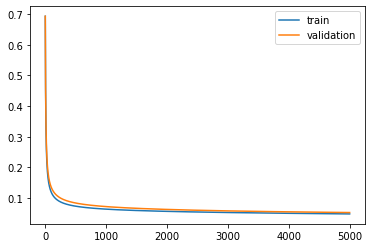

In [4]:
import matplotlib.pyplot as plt
plt.plot(range(5000), test_train_losses, label="train")
plt.plot(range(5000), test_val_losses, label="validation")
plt.legend()
plt.show()

In [5]:
# Part 2: TensorFlow2 implementation of logistic regression 

class TFLogReg:
    def __init__(self, x_train, y_train, x_val, y_val, epochs, alpha, reg, tol, batch_size):
        self.x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
        self.y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        self.x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
        self.y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
        self.epochs = epochs
        self.alpha = alpha
        self.reg = reg
        self.tol = tol
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(self.x_train.shape[0] / batch_size))
        # Initialize the weights
        self.w = tf.Variable(tf.random.truncated_normal((self.x_train.shape[1], 1), stddev=0.5), dtype=tf.float32)
        # self.w = tf.Variable(tf.zeros((self.x_train.shape[1], 1)), dtype = tf.float32)
        self.b = tf.Variable(0.0, dtype=tf.float32)
        self.old_w = tf.identity(self.w)
        # Initialize the optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha)
        self.old_e = np.Inf
        # self.loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    
    def forward(self, x):
      outputs = x @ self.w + self.b
      probs = tf.math.sigmoid(outputs)
      return probs
    
    def loss(self, z, y):
      # z = tf.clip_by_value(z, 1e-9, 1.0)
      # Gradient clipping for stability
      z = tf.clip_by_value(z, 1e-7, 1 - 1e-7)
      # Make sure both are flat for 
      z = tf.reshape(z, [-1])
      y = tf.reshape(y, [-1])
      loss = tf.math.reduce_mean(-1 * y * tf.math.log(z) - (1 - y) * tf.math.log(1 - z)) + self.reg * (tf.norm(self.w) ** 2)
      return loss
        
    def train(self):
      # Store training information in lists
      train_losses = []
      val_losses = []
      train_acces = []
      val_acces = []
            
      # Train for specified number of epochs
      for epoch in range(self.epochs):
        # Shuffle data each epoch
        # Taken from: https://valueml.com/shuffle-the-training-data-in-tensorflow/
        indices = tf.range(start=0, limit=self.x_train.shape[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)
        shuffled_x_train = tf.gather(self.x_train, shuffled_indices)
        shuffled_y_train = tf.gather(self.y_train, shuffled_indices)
        x_batches = tf.split(shuffled_x_train, self.num_batches)
        y_batches = tf.split(shuffled_y_train, self.num_batches)
                
        for x_batch, y_batch in zip(x_batches, y_batches):
          with tf.GradientTape() as tape:
            outputs = self.forward(x_batch)
            loss = self.loss(outputs, y_batch)
    
          # Calculate the training loss and accuracy
          train_losses.append(loss.numpy())
          outputs_label = tf.where(outputs > 0.5, tf.ones_like(outputs), outputs)
          outputs_label = tf.where(outputs_label <= 0.5, tf.zeros_like(outputs_label), outputs_label)
          train_accuracy = tf.math.reduce_sum(tf.cast(tf.equal(outputs_label, y_batch), dtype=tf.float32)).numpy() / outputs_label.shape[0]
          train_acces.append(train_accuracy)
                    
          # Calculate the validation loss and accuracy
          outputs_val = self.forward(self.x_val)
          val_loss = self.loss(outputs_val, self.y_val)
          val_losses.append(val_loss.numpy())
          outputs_val_label = tf.where(outputs_val > 0.5, tf.ones_like(outputs_val), outputs_val)
          outputs_val_label = tf.where(outputs_val_label <= 0.5, tf.zeros_like(outputs_val_label), outputs_val_label)
          val_accuracy = tf.math.reduce_sum(tf.cast(tf.equal(outputs_val_label, self.y_val), dtype=tf.float32)).numpy() / outputs_val_label.shape[0]
          val_acces.append(val_accuracy)
                    
          # Perform gradient descent with optimizer
          dw, db = tape.gradient(loss, [self.w, self.b])
          grads = [dw, db]
          self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))

          if tf.norm(self.w - self.old_w).numpy() <= self.tol:
            return train_losses, val_losses, train_acces, val_acces
          # if tf.math.abs(self.old_e - val_loss) <= self.tol:
          #   return train_losses, val_losses, train_acces, val_acces

          # self.old_e = val_loss
          self.old_w = tf.identity(self.w)
               
      return train_losses, val_losses, train_acces, val_acces

In [6]:
tensor_log = TFLogReg(trainData, trainTarget, validData, validTarget, 700, 0.001, 0, 1e-7, 500)

In [7]:
train_losses, val_losses, train_acces, val_acces = tensor_log.train()

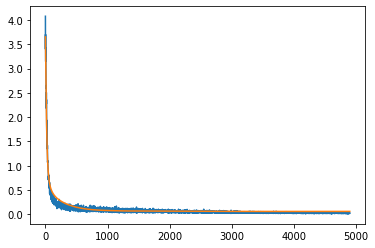

In [8]:
train_losses[-1]

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.show()

In [9]:
print(train_acces[0])
print(train_acces[-1])
print(train_losses[-1])
print(val_losses[-1])

0.406
0.994
0.023615636
0.05893355


In [10]:
train_losses[-50:]

[0.032928832,
 0.026086938,
 0.014185466,
 0.038245857,
 0.023363596,
 0.013260544,
 0.03533939,
 0.016954714,
 0.014114412,
 0.032994863,
 0.013241501,
 0.035769586,
 0.031102672,
 0.0229804,
 0.017338142,
 0.022563642,
 0.02600886,
 0.014591914,
 0.021430638,
 0.026666122,
 0.03326708,
 0.02239536,
 0.034751806,
 0.03978886,
 0.012206037,
 0.021033876,
 0.029198615,
 0.014367118,
 0.015626648,
 0.037355226,
 0.021340825,
 0.012079506,
 0.03580206,
 0.024968766,
 0.017658735,
 0.018926583,
 0.022085035,
 0.02081158,
 0.032022506,
 0.027940152,
 0.016259687,
 0.014816993,
 0.03209775,
 0.03637969,
 0.021894846,
 0.021681715,
 0.02014473,
 0.01824094,
 0.024440873,
 0.023615636]

In [11]:
validData.shape

(100, 784)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

number_of_features = trainData.shape[1]
model = Sequential()
model.add(Dense(1,activation = 'sigmoid',input_dim = number_of_features))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')
history = model.fit(trainData, trainTarget, batch_size=500, epochs=500, validation_data=(validData,validTarget))

Epoch 1/500
7/7 [==============================] - 1s 31ms/step - loss: 0.4007 - val_loss: 0.3049
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2424 - val_loss: 0.2130
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1712 - val_loss: 0.1679
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.1367 - val_loss: 0.1434
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1181 - val_loss: 0.1285
Epoch 6/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1068 - val_loss: 0.1198
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0991 - val_loss: 0.1131
Epoch 8/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0939 - val_loss: 0.1074
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0896 - val_loss: 0.1034
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0864 - val_loss: 0.1001
Epoch 11/500
7/7 [==========

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [14]:
# PyTorch Implementation

In [15]:
train_losses

[4.0774236,
 3.400851,
 3.7032769,
 3.4107683,
 3.1453323,
 3.3884475,
 3.422687,
 3.1891074,
 2.9427052,
 3.018506,
 2.760792,
 2.5930445,
 2.6516242,
 2.5212905,
 2.1810493,
 2.5072982,
 2.2696688,
 2.3607717,
 2.1984572,
 2.0512118,
 1.8438114,
 1.9194696,
 1.5504359,
 1.9077114,
 1.9332292,
 1.608305,
 1.4641219,
 1.6457902,
 1.4425857,
 1.5167356,
 1.4068061,
 1.3437045,
 1.4189843,
 1.1684879,
 1.1699226,
 1.0687462,
 1.1005516,
 1.0936165,
 1.095761,
 1.0684366,
 1.0143303,
 1.0601907,
 0.95328206,
 0.91816324,
 0.893703,
 0.89746726,
 0.83372813,
 0.81589496,
 0.7922544,
 0.7044823,
 0.78502995,
 0.7074999,
 0.8113994,
 0.78445697,
 0.66808397,
 0.62222916,
 0.66443956,
 0.57563794,
 0.62894046,
 0.5854216,
 0.6344352,
 0.59753346,
 0.658342,
 0.53449655,
 0.54370934,
 0.5397419,
 0.53958225,
 0.65391475,
 0.4235561,
 0.5751332,
 0.43159035,
 0.5250467,
 0.5186263,
 0.4492635,
 0.49880788,
 0.47170272,
 0.4966141,
 0.4870794,
 0.47191322,
 0.48483342,
 0.3934846,
 0.43248504,
 